# BatFlightAnalysis

## Paquetes

In [38]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import wilcoxon

from BatFlightAnalysis import read_data, split_data

## Funciones

In [39]:
def curvatura(df):
    # Convertir a arrays de numpy
    x = np.array(df['x'])
    y = np.array(df['y'])
    z = np.array(df['z'])

    # Calcular las derivadas usando diferencias finitas
    dx = np.gradient(x)
    dy = np.gradient(y)
    dz = np.gradient(z)

    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    ddz = np.gradient(dz)

    # Calcular la curvatura
    curvatura = np.zeros(len(x))

    for i in range(len(x)):
        # Vectores de la primera y segunda derivada
        r_prime = np.array([dx[i], dy[i], dz[i]])
        r_double_prime = np.array([ddx[i], ddy[i], ddz[i]])
        
        # Producto cruzado de r' y r''
        cross_product = np.cross(r_prime, r_double_prime)
        
        # Magnitud de r'
        norm_r_prime = np.linalg.norm(r_prime)
        
        # Curvatura
        curvatura[i] = np.linalg.norm(cross_product) / (norm_r_prime**3)

    # Desviación Estándar de la curvatura
    std_curvatura = np.std(curvatura)

    # Media de la curvatura
    mean_curvatura = np.mean(curvatura)

    # Integral de la curvatura
    integral_curvatura = np.trapz(curvatura)

    return mean_curvatura, std_curvatura, integral_curvatura

In [40]:
def longitud(df):
    # Convertir a arrays de numpy
    x = np.array(df['x'])
    y = np.array(df['y'])
    z = np.array(df['z'])

    # Longitud de la trayectoria
    longitud = np.zeros(len(x))

    for i in range(1, len(x)):
        longitud[i] = longitud[i-1] + np.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2 + (z[i] - z[i-1])**2)

    # Longitud total
    longitud_total = longitud[-1]

    return longitud_total

In [41]:
def var_espacial(df):
    # Convertir a arrays de numpy
    x = np.array(df['x'])
    y = np.array(df['y'])
    z = np.array(df['z'])

    longitud_x = np.max(x) - np.min(x)
    longitud_y = np.max(y) - np.min(y)
    longitud_z = np.max(z) - np.min(z)

    volumen = longitud_x * longitud_y * longitud_z

    return longitud_x, longitud_y, longitud_z, volumen


In [42]:
def hist_plots(whiskers_data, no_whiskers_data, metric):
    print(f"Normality test for {metric}:")
    # Perform normality check for "whiskers" and "no whiskers" groups and plot histograms
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram for 'whiskers'
    axes[0].hist(whiskers_data[metric], bins=15, edgecolor='black', alpha=0.7)
    axes[0].set_title(f'Histogram of {metric} (Whiskers)')


    # Histogram for 'no whiskers'
    axes[1].hist(no_whiskers_data[metric], bins=15, edgecolor='black', alpha=0.7)
    axes[1].set_title(f'Histogram of {metric} (No Whiskers)')

    plt.tight_layout()
    plt.show()

## Código

### Lectura de datos

In [43]:
data_bef, data_fee, data_aft = read_data('data/output_points_1_no_whiskers.xlsx')

In [44]:
# Split data into flower and bat data; before, during, and after feeding
flower_bef, flower_fee, flower_aft, bat_bef, bat_fee, bat_aft = split_data(data_bef, data_fee, data_aft)

# Show the data
print(flower_fee.head())

      x    y      z
9   281   94  349.0
10  283   98  345.0
11  283  100  341.0
12  283  103  338.0
13  288  103  336.0


### Curvatura

In [45]:
mean_curvatura, std_curvatura, int_curvatura = curvatura(flower_fee)
print('Desviación Estándar de la Curvatura:', std_curvatura)
print('Media de la Curvatura:', mean_curvatura)
print('Integral de la Curvatura:', int_curvatura)

Desviación Estándar de la Curvatura: 1.8368621915524173
Media de la Curvatura: 0.5475373323457154
Integral de la Curvatura: 43.19156036642262


### Longitud

In [46]:
# Longitud total
longitud_total = longitud(flower_fee)
print('Longitud Total:', longitud_total)

Longitud Total: 375.82886152263075


### Variación en cada eje

In [47]:
# Variación en cada eje
longitud_x, longitud_y, longitud_z, volumen = var_espacial(flower_fee)

print('Longitud de la trayectoria en el eje x:', longitud_x)
print('Longitud de la trayectoria en el eje y:', longitud_y)
print('Longitud de la trayectoria en el eje z:', longitud_z)
print('Volumen del Espacio:', volumen)

Longitud de la trayectoria en el eje x: 14
Longitud de la trayectoria en el eje y: 15
Longitud de la trayectoria en el eje z: 17.0
Volumen del Espacio: 3570.0


## Iteración sobre archivos

In [48]:
individuo, whiskers, n_vuelo = [], [], []
mean_curvatura, std_curvatura, int_curvatura = [], [], []
longitud_total = []
longitud_x, longitud_y, longitud_z, volumen = [], [], [], []

for n in range(6,10):
    # for tipo in ["Whiskers"]:
    for tipo in ["Whiskers", "No whiskers"]:
        # Recorro lo archivos de la capeta Individuo n
        for file in os.listdir(f'data/Individuo {n}/{tipo}'):
            # print("Procesando:", f"Individuo {n}/{tipo}/{file}")

            try:
                data_bef, data_fee, data_aft = read_data(f'data/Individuo {n}/{tipo}/{file}')

                # Split data into flower and bat data; before, during, and after feeding
                flower_bef, flower_fee, flower_aft, bat_bef, bat_fee, bat_aft = split_data(data_bef, data_fee, data_aft)

                # Curvatura
                mean_curv, std_curv, int_curv = curvatura(flower_fee)
                mean_curvatura.append(mean_curv)
                std_curvatura.append(std_curv)
                int_curvatura.append(int_curv)

                # Longitud total
                long = longitud(flower_fee)
                longitud_total.append(long)

                # Variación en cada eje
                long_x, long_y, long_z, vol = var_espacial(flower_fee)
                longitud_x.append(long_x)
                longitud_y.append(long_y)
                longitud_z.append(long_z)
                volumen.append(vol)

                individuo.append(n)
                whiskers.append(tipo)
                n_vuelo.append(file.split('_')[-1].split('.')[0])
            except:
                print("Error en el archivo:", f"Individuo {n}/{tipo}/{file}")

# Creo el conjunto de datos
df = pd.DataFrame({
    'Individuo': individuo,
    'Tipo': whiskers,
    'No. Vuelo': n_vuelo,
    'Curvatura Media': mean_curvatura,
    'Desviación Estándar de la Curvatura': std_curvatura,
    'Integral de la Curvatura': int_curvatura,
    'Longitud Total': longitud_total,
    'Longitud en X': longitud_x,
    'Longitud en Y': longitud_y,
    'Longitud en Z': longitud_z,
    'Volumen': volumen
})

# Muestro los datos
display(df.head())

Error en el archivo: Individuo 6/No whiskers/output_points_7.xlsx


C:\Users\matea\AppData\Local\Temp/ipykernel_4296/2953519617.py:31: RuntimeWarning: invalid value encountered in scalar divide
  curvatura[i] = np.linalg.norm(cross_product) / (norm_r_prime**3)
C:\Users\matea\AppData\Local\Temp/ipykernel_4296/2953519617.py:31: RuntimeWarning: invalid value encountered in scalar divide
  curvatura[i] = np.linalg.norm(cross_product) / (norm_r_prime**3)


,Individuo,Tipo,No. Vuelo,Curvatura Media,Desviación Estándar de la Curvatura,Integral de la Curvatura,Longitud Total,Longitud en X,Longitud en Y,Longitud en Z,Volumen
0,6,Whiskers,1,0.319137,0.309382,5.333128,75.694841,18.0,14.0,19.0,4788.0
1,6,Whiskers,10,0.061655,0.072966,1.756422,260.010676,54.0,40.0,125.0,270000.0
2,6,Whiskers,11,1.097282,3.454947,19.665025,80.997540,7.0,21.0,18.0,2646.0
3,6,Whiskers,12,0.128108,0.231968,2.129493,131.251894,21.0,40.0,93.0,78120.0
4,6,Whiskers,13,0.255117,0.302641,3.785561,58.087628,10.0,11.0,16.0,1760.0


In [49]:
# Guardo los datos
df.to_excel('data/mediciones.xlsx', index=False)

## Análisis comparativo

In [50]:
# Leo el archivo de datos
data = pd.read_excel('data/mediciones.xlsx')

display(data.head())

,Individuo,Tipo,No. Vuelo,Curvatura Media,Desviación Estándar de la Curvatura,Integral de la Curvatura,Longitud Total,Longitud en X,Longitud en Y,Longitud en Z,Volumen
0,6,Whiskers,1,0.319137,0.309382,5.333128,75.694841,18,14,19.0,4788.0
1,6,Whiskers,10,0.061655,0.072966,1.756422,260.010676,54,40,125.0,270000.0
2,6,Whiskers,11,1.097282,3.454947,19.665025,80.997540,7,21,18.0,2646.0
3,6,Whiskers,12,0.128108,0.231968,2.129493,131.251894,21,40,93.0,78120.0
4,6,Whiskers,13,0.255117,0.302641,3.785561,58.087628,10,11,16.0,1760.0


In [51]:
metrics = ['Curvatura Media', 'Desviación Estándar de la Curvatura', 'Integral de la Curvatura', 'Longitud Total', 'Longitud en X', 'Longitud en Y', 'Longitud en Z', 'Volumen']

data.columns = data.columns.str.replace(" ", "_")
metrics = [metric.replace(" ", "_") for metric in metrics]

Normality test for Curvatura_Media:


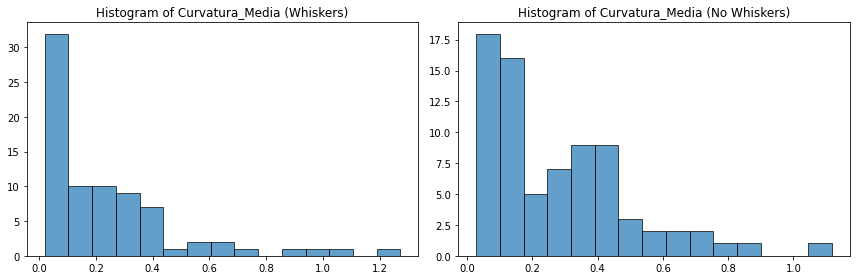

Normality test for Desviación_Estándar_de_la_Curvatura:


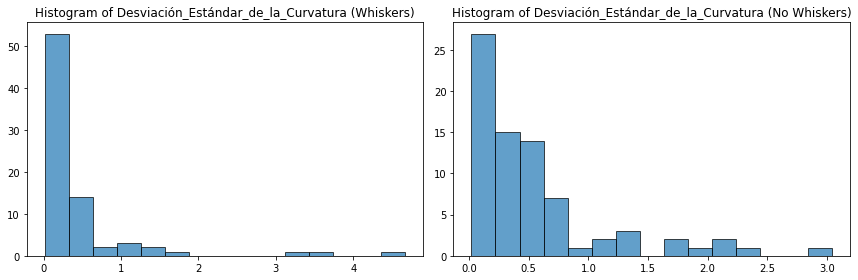

Normality test for Integral_de_la_Curvatura:


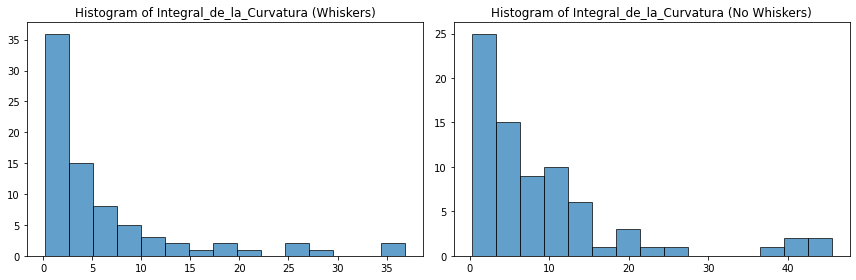

Normality test for Longitud_Total:


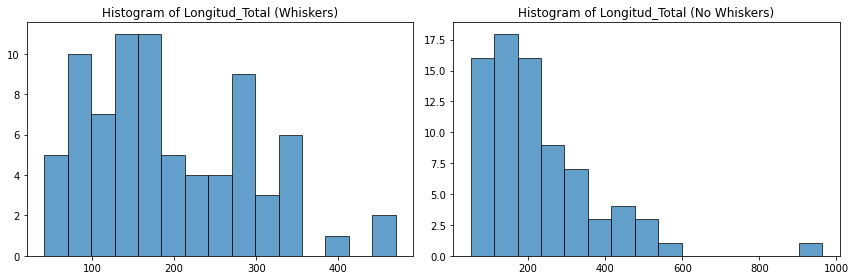

Normality test for Longitud_en_X:


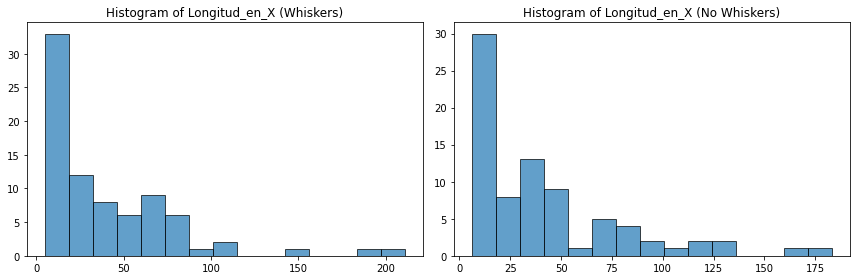

Normality test for Longitud_en_Y:


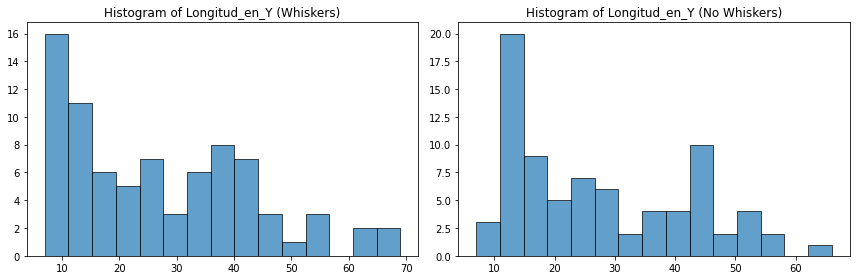

Normality test for Longitud_en_Z:


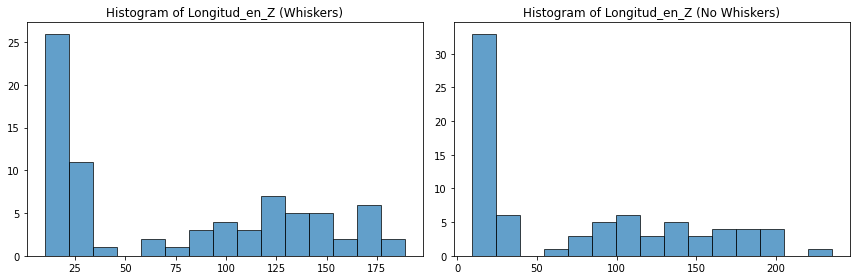

Normality test for Volumen:


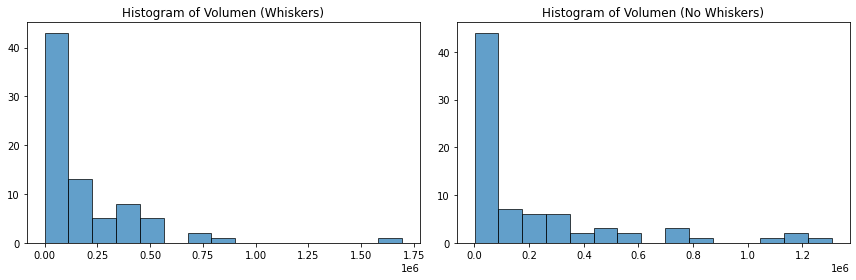

In [52]:
# Separate data based on "Tipo" (whiskers or no whiskers)
whiskers_data = data[data['Tipo'] == 'Whiskers']
no_whiskers_data = data[data['Tipo'] == 'No whiskers']

for metric in metrics:
    hist_plots(whiskers_data, no_whiskers_data, metric)

Modelo lineal mixto

In [53]:
for metric in metrics:
    print(f"Modelo lineal mixto para {metric}:")

    cleaned_data = data.dropna(subset=[metric, "Tipo"])

    # Re-attempt fitting the linear mixed effects model
    model = smf.mixedlm(f"{metric} ~ Tipo", cleaned_data, groups=cleaned_data["Individuo"])
    result = model.fit()

    # Summarize the results of the mixed effects model
    display(result.summary())

Modelo lineal mixto para Curvatura_Media:


c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Curvatura_Media
No. Observations: 154     Method:             REML           
No. Groups:       4       Scale:              0.0570         
Min. group size:  37      Log-Likelihood:     -3.2575        
Max. group size:  41      Converged:          Yes            
Mean group size:  38.5                                       
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.282    0.033  8.619 0.000  0.218  0.347
Tipo[T.Whiskers]   -0.044    0.038 -1.152 0.249 -0.120  0.031
Group Var           0.001    0.009                           
=============================================================

"""

Modelo lineal mixto para Desviación_Estándar_de_la_Curvatura:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Curvatura
No. Observations: 154     Method:             REML                               
No. Groups:       4       Scale:              0.4617                             
Min. group size:  37      Log-Likelihood:     -163.1176                          
Max. group size:  41      Converged:          Yes                                
Mean group size:  38.5                                                           
-------------------------------------------------------------------------------------
                       Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-------------------------------------------------------------------------------------
Intercept               0.567        0.115      4.916     0.000      0.341      0.792
Tipo[T.Whiskers]       -0.117        0.110     -1.065     0.287     -0.331      0.098
Group Var               0.029        0.050                                           
=================================================================================

"""

Modelo lineal mixto para Integral_de_la_Curvatura:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: Integral_de_la_Curvatura
No. Observations: 154     Method:             REML                    
No. Groups:       4       Scale:              82.3734                 
Min. group size:  37      Log-Likelihood:     -556.9793               
Max. group size:  41      Converged:          Yes                     
Mean group size:  38.5                                                
------------------------------------------------------------------------
                    Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
------------------------------------------------------------------------
Intercept            9.125      1.488    6.134   0.000    6.209   12.040
Tipo[T.Whiskers]    -2.977      1.463   -2.035   0.042   -5.845   -0.110
Group Var            4.514      0.609                                   
======================================================================

"""

Modelo lineal mixto para Longitud_Total:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM Dependent Variable: Longitud_Total
No. Observations:   156     Method:             REML          
No. Groups:         4       Scale:              15484.3488    
Min. group size:    38      Log-Likelihood:     -967.2187     
Max. group size:    41      Converged:          Yes           
Mean group size:    39.0                                      
--------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        227.307   19.129 11.883 0.000 189.816 264.799
Tipo[T.Whiskers] -33.486   19.929 -1.680 0.093 -72.546   5.575
Group Var        669.314    7.081                             
==============================================================

"""

Modelo lineal mixto para Longitud_en_X:


c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\mode

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:              MixedLM Dependent Variable: Longitud_en_X
No. Observations:   159     Method:             REML         
No. Groups:         4       Scale:              1371.9517    
Min. group size:    38      Log-Likelihood:     -797.0472    
Max. group size:    42      Converged:          No           
Mean group size:    39.8                                     
-------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------
Intercept         41.477    8.072  5.138 0.000  25.656 57.297
Tipo[T.Whiskers]  -0.973    5.875 -0.166 0.868 -12.488 10.542
Group Var        191.089    7.183                            
=============================================================

"""

Modelo lineal mixto para Longitud_en_Y:


c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\mode

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Longitud_en_Y
No. Observations: 159     Method:             REML         
No. Groups:       4       Scale:              221.6112     
Min. group size:  38      Log-Likelihood:     -653.6088    
Max. group size:  42      Converged:          No           
Mean group size:  39.8                                     
-----------------------------------------------------------
                  Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         27.395    2.955 9.269 0.000 21.602 33.188
Tipo[T.Whiskers]   0.259    2.361 0.110 0.913 -4.369  4.887
Group Var         23.711    1.430                          
===========================================================

"""

Modelo lineal mixto para Longitud_en_Z:


c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\mode

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:             MixedLM Dependent Variable: Longitud_en_Z
No. Observations:  156     Method:             REML         
No. Groups:        4       Scale:              3929.8573    
Min. group size:   38      Log-Likelihood:     -861.1105    
Max. group size:   41      Converged:          No           
Mean group size:   39.0                                     
------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------
Intercept        76.902    8.539  9.006 0.000  60.166 93.638
Tipo[T.Whiskers] -1.276   10.039 -0.127 0.899 -20.953 18.401
Group Var        90.087    3.127                            
============================================================

"""

Modelo lineal mixto para Volumen:


c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\matea\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\mode

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                 MixedLM      Dependent Variable:      Volumen         
No. Observations:      156          Method:                  REML            
No. Groups:            4            Scale:                   81127558501.7978
Min. group size:       38           Log-Likelihood:          -2157.9727      
Max. group size:       41           Converged:               No              
Mean group size:       39.0                                                  
-----------------------------------------------------------------------------
                     Coef.       Std.Err.   z    P>|z|    [0.025     0.975]  
-----------------------------------------------------------------------------
Intercept            197605.764 38435.633  5.141 0.000  122273.308 272938.220
Tipo[T.Whiskers]     -20690.167 45616.658 -0.454 0.650 -110097.174  68716.840
Group Var        1747369904.723 11853.710                                    
=============================================================================

"""

Prueba no paramétrica de Wilcoxon

In [54]:
for metric in metrics:
    print(f"Wilcoxon para {metric}:")

    paired_data = cleaned_data.pivot_table(index="Individuo", columns="Tipo", values=metric)

    wilcoxon_test_result = wilcoxon(paired_data["Whiskers"], paired_data["No whiskers"])

    print(wilcoxon_test_result)

Wilcoxon para Curvatura_Media:
WilcoxonResult(statistic=3.0, pvalue=0.625)
Wilcoxon para Desviación_Estándar_de_la_Curvatura:
WilcoxonResult(statistic=2.0, pvalue=0.375)
Wilcoxon para Integral_de_la_Curvatura:
WilcoxonResult(statistic=0.0, pvalue=0.125)
Wilcoxon para Longitud_Total:
WilcoxonResult(statistic=1.0, pvalue=0.25)
Wilcoxon para Longitud_en_X:
WilcoxonResult(statistic=5.0, pvalue=1.0)
Wilcoxon para Longitud_en_Y:
WilcoxonResult(statistic=5.0, pvalue=1.0)
Wilcoxon para Longitud_en_Z:
WilcoxonResult(statistic=4.0, pvalue=0.875)
Wilcoxon para Volumen:
WilcoxonResult(statistic=1.0, pvalue=0.25)
